<a href="https://colab.research.google.com/github/ssubbinn/ESAA-OB/blob/main/3%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 7 앙상블 학습과 랜덤 포레스트

### 7.1 투표 기반 분류기

- 좋은 분류기를 만드는 방법 -> 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것 (직접투표 분류기)

- 하지만 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 가능

In [2]:
# moons 데이터 불러오기

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

# train, test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)   

In [3]:
# 여러 분류기를 조합하여 사이킷런의 투표 기반 분류기(VotingClassifier)를 만들고 훈련시킴

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [4]:
#각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

#투표 기반 분류기가 다른 개별 분류기보다 성능 좋음!

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.896
VotingClassifier 0.904


- 모든 분류기가 클래스의 확률을 예측할 수 있으면 (predict_proba() 메서드가 있으면) 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스 예측가능 -> 이를 간접 투표라고 한다
- 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음
- 이 방식을 사용하기 위해서는 voting="hard"를 voting="soft"로 바꾸고 모든 분류기가 클래스의 확률을 추정할 수 있으면 됨

### 7.2 배깅과 페이스팅

다양한 분류기를 만드는 한 가지 방법은 각기 다른 훈련 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것

- 배깅 : 훈련 세트에서 중복을 허용하여 샘플링 하는 방식
- 페이스팅 : 훈련 세트에서 중복을 허용하지 않고 샘플링 하는 방식

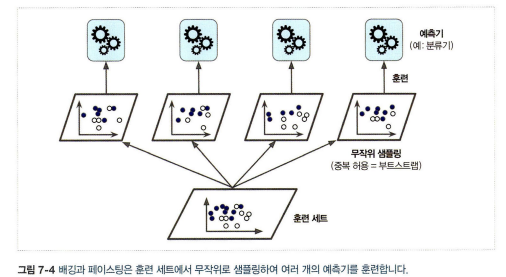

- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦
- 수집함수는 전형적으로 분류일 때는 통계적 최빈값 / 회귀일때는 평균
- 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소

**7.2.1 사이킷런의 배깅과 페이스팅**

- 사이킷런은 BaggingClassifier, BaggingRegressor 제공

In [5]:
# 결정트리분류기 500개의 앙상블을 훈련시키는 코드
# 각 분류기는 훈련 세트에서 중복을 혀용하여 무작위로 선택된 100개의 샘플로 훈련(배깅)
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples=100, bootstrap=True, n_jobs=-1) #페이스팅의 경우 bootstrap=False지정
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

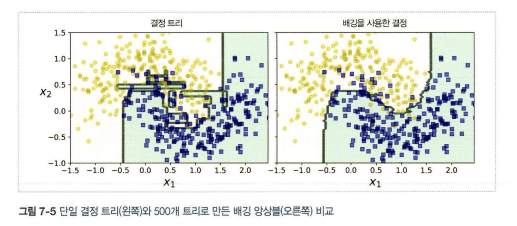

- 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘됨
- 앙상블은 비슷한 편향에서 더 작은 분산을 만든다
- 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높다
- 일반적으론 배깅 성능이 더 좋음

**7.2.2 oob 평가**

- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음
- BaggingClassifier의 경우 평균적으로 각 예측기에 훈련  샘플의 63% 정도만 샘플링 된다는 것을 의미. 나머지 37%를 oob샘플이라고 부름
- 별도의 검증 세트를 사용하지 않고 oob 샘플을 이용해 평가할 수 있음

In [6]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True) #oob_score=True 지정해주면 자동으로 oob평가 수행

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [7]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

둘의 결과가 상당히 비슷!

In [8]:
bag_clf.oob_decision_function_

array([[0.34536082, 0.65463918],
       [0.35820896, 0.64179104],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.07909605, 0.92090395],
       [0.34594595, 0.65405405],
       [0.01648352, 0.98351648],
       [0.98837209, 0.01162791],
       [0.97395833, 0.02604167],
       [0.76649746, 0.23350254],
       [0.01111111, 0.98888889],
       [0.75      , 0.25      ],
       [0.8603352 , 0.1396648 ],
       [0.9726776 , 0.0273224 ],
       [0.06179775, 0.93820225],
       [0.        , 1.        ],
       [0.97126437, 0.02873563],
       [0.92655367, 0.07344633],
       [1.        , 0.        ],
       [0.015625  , 0.984375  ],
       [0.3655914 , 0.6344086 ],
       [0.93939394, 0.06060606],
       [1.        , 0.        ],
       [0.96373057, 0.03626943],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.69892473, 0.30107527],
       [0.

### 7.3 랜덤 패치와 랜덤 서브스페이스

- 랜덤 패치 방식 : 훈련 특성과 샘플을 모두 샘플링하는 것

- 랜덤 서브스페이스 방식 : 훈련 샘플을 모두 사용하고(bootstrap=False, max_samples=1.0) 특성은 샘플링(bootstrap_feaures=True 또는 max_features<1.0)하는 것

- 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춘다.

### 7.4 랜덤 포레스트

- 랜덤 포레스트는 일반적으로 배깅 방법을 적용한 결정트리의 앙상블
- max_samples를 훈련 세트의 크기로 지정

In [9]:
# 500개 트리로 이루어진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드

from sklearn.ensemble import RandomForestClassifier

rnd_clf= RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf=rnd_clf.predict(X_test)

- RandomForestClassifier는 DecisionTreeClassifier의 매개변수와 앙상블 자체를 제어하는 데 필요한 BaggingClassifier의 매개변수를 모두 가지고 있음
- 랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적을 특성을 찾는 식으로 무작위성을 더 주입함

In [10]:
#BaggingClassifier를 사용하여 앞을 RandomForestClassifier와 거의 유사하게 만든 것
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

**7.4.1 엑스트라 트리**

- 익스트림 랜덤 트리(엑스트라 트리) : 극단적으로 무작위한 트리의 랜덤 포레스트 -> 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠름

**7.4.2 특성 중요도**

- 랜덤 포레스트의 장점 : 특성의 상대적 중요도를 측정하기 쉬움

- 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도 측정
- 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도와 전체 합이 1이 되도록 결괏값을 정규화함 (feature_importances_)

In [11]:
from sklearn.datasets import load_iris
iris=load_iris()
rnd_clf=RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name,score)

sepal length (cm) 0.10037208337579177
sepal width (cm) 0.024198503753032587
petal length (cm) 0.40926518291525765
petal width (cm) 0.4661642299559181


### 7.5 부스팅

부스팅 : 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법. 앞의 모델을 보완해나가면서 일련의 예측기를 학습

**7.5.1 에이다부스트**

- 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높여서 보완. 계속 반복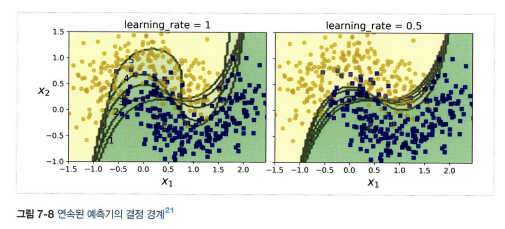

- 첫번째 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아짐
- 따라서 두번째 분류기는 이 샘플들을 더 정확이 예측하게 됨
- 모든 예측기가 훈련을 마치면 배깅.페이스팅과 비슷한 방식으로 예측을 만듦

In [12]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200,algorithm='SAMME.R',learning_rate=0.5)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

**7.5.2 그레이디언트 부스팅**

- 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가
- 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습

In [13]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

# 첫번째 예측기에서 생긴 잔여 오차에 두번째 DecisionTreeRegressor 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [14]:
# 두번째 예측기가 만든 잔여 오차에 세번째 회귀 모델 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [ ]:
# 모든 트리의 예측의 합
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1,tree_reg2,tree_reg3))

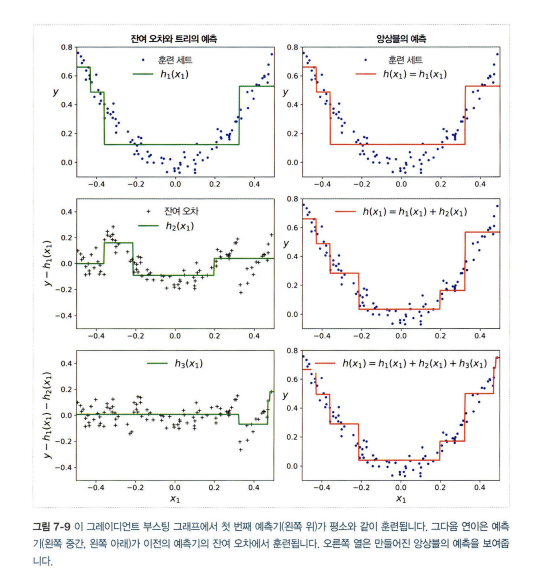

- 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아짐

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=1.0)
gbrt.fit(X,y)

#learning_rate : 각 트리의 기여 정도 조절 (0.1정도)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

- learning_rate : 각 트리의 기여 정도 조절 

-> 0.1정도 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 예측 성능은 좋아짐

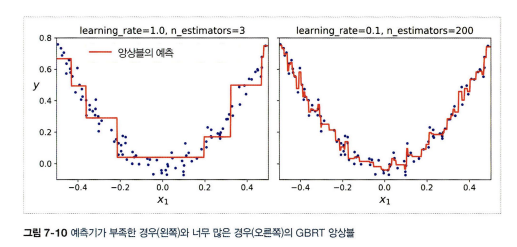

- 왼쪽은 훈련 세트를 학습하기에는 트리가 충분하지 않음. 오른쪽은 트리가 너무 많음(과대적합)

In [17]:
#조기종료 기법 -> 최적의 트리수 찾기
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)
gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=120)
gbrt.fit(X_train,y_train)

errors = [mean_squared_error(y_val,y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators=np.argmin(errors)+1

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=91)

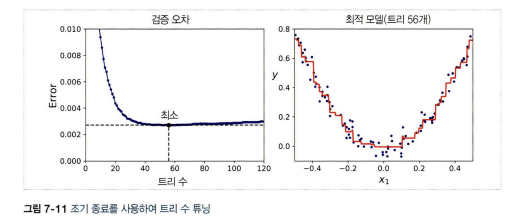

In [18]:
# 조기 종료 구현 (warm_start = True)

gbrt = GradientBoostingRegressor(max_depth=2,warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train,y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val,y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break #조기 종료

- 확률적 그레이디언트 부스팅 : 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정한다. 편향이 높아지는 대신 분산이 낮아지고 훈련 속도가 높아진다.

In [19]:
#XGboost
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train,y_train)
y_pred = xgb_reg.predict(X_val)

In [20]:
#자동 조기 종료 기능 제공
xgb_reg.fit(X_train,y_train,eval_set=[(X_val,y_val)],early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.40440
[1]	validation_0-rmse:0.34762
[2]	validation_0-rmse:0.31838
[3]	validation_0-rmse:0.29874
[4]	validation_0-rmse:0.29403
[5]	validation_0-rmse:0.29981


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


### 7.6 스태킹

- 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델 훈련

- 새로운 샘플에 회귀 작업을 수행하는 앙상블에서, 기존의 세 예측기는 각각 다른 값을 예측하고 마지막 예측기(블렌더 또는 메타 학습기)가 이 예측을 입력으로 받아 최종 예측을 만든다. 
- 블렌더는 일반적으로 홀드아웃 세트를 사용해서 학습시킨다. 먼저 훈련 세트를 2개의 서브셋으로 나누고, 첫번째 서브셋은 첫번째 레이어의 예측을 훈련시키기 위해 사용한다. 그 다음 첫번째 레이어의 예측기를 사용해 두번째(홀드아웃) 세트에 대한 예측을 만든다. 홀드아웃 세트의 각 샘플에 대해 3개의 예측값이 있는데, 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있다.